In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------
# LOAD DATA
# ----------------------
df = pd.read_csv(r"E:\Sample - Superstore.csv", encoding="latin1")
df['Order Date'] = pd.to_datetime(df['Order Date'])

df = df[['Order Date','Category','Sales','Discount','Quantity','Ship Mode','Region']]

# ----------------------
# ONE-HOT ENCODE CATEGORICALS
# ----------------------
df = pd.get_dummies(df, columns=['Ship Mode','Region'], drop_first=True)

# ----------------------
# GENTLE OUTLIER SMOOTHING
# ----------------------
def cap(x):
    q99 = x.quantile(0.99)
    return np.where(x>q99, q99, x)

df['Sales'] = df.groupby('Category')['Sales'].transform(cap)

# ----------------------
# WEEKLY AGGREGATION
# ----------------------
weekly = (
    df.groupby(['Category', pd.Grouper(key='Order Date', freq='W')])
      .agg({
          'Sales':'sum',
          'Discount':'mean',
          'Quantity':'sum',
          **{c:'mean' for c in df.columns if 'Ship Mode_' in c or 'Region_' in c}
      })
      .reset_index()
)

weekly = weekly.rename(columns={'Order Date':'ds','Sales':'y'})

reg_cols = [c for c in weekly.columns if c not in ['Category','ds','y']]

# ----------------------
# METRIC FUNCTIONS
# ----------------------
def smape(y, yhat):
    return 100/len(y)*np.sum(2*np.abs(yhat-y)/(np.abs(y)+np.abs(yhat)+1e-9))

def wape(y, yhat):
    return np.sum(np.abs(yhat-y))/np.sum(np.abs(y))*100

results=[]
all_fc=[]

# ----------------------
# RUN PER CATEGORY
# ----------------------
for cat in weekly['Category'].unique():

    cat_df = weekly[weekly['Category']==cat].copy()

    split = cat_df['ds'].iloc[-12]  # last 12 weeks test
    train = cat_df[cat_df['ds'] < split]
    test  = cat_df[cat_df['ds'] >= split]

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=0.15
    )

    # ADD REGRESSORS
    for col in reg_cols:
        model.add_regressor(col)

    model.fit(train[['ds','y'] + reg_cols])

    future = cat_df[['ds'] + reg_cols].copy()
    fc = model.predict(future)

    merged = fc[['ds','yhat']].merge(cat_df[['ds','y']], on='ds')
    err = merged[merged['ds'].isin(test['ds'])]

    y = err['y']
    yhat = err['yhat']

    results.append({
        "Category":cat,
        "MAE":mean_absolute_error(y,yhat),
        "RMSE":np.sqrt(mean_squared_error(y,yhat)),
        "WAPE":wape(y,yhat),
        "SMAPE":smape(y,yhat)
    })

    f = fc[['ds','yhat']].copy()
    f['Category']=cat
    all_fc.append(f)

# ----------------------
# EXPORT
# ----------------------
metrics = pd.DataFrame(results)
forecast = pd.concat(all_fc)

metrics.to_csv("forecast_metrics_with_regressors.csv",index=False)
forecast.to_csv("forecast_powerbi_with_regressors.csv",index=False)

print(metrics)


14:27:28 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:38 - cmdstanpy - INFO - Chain [1] start processing
14:27:40 - cmdstanpy - INFO - Chain [1] done processing
14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing


          Category          MAE         RMSE       WAPE      SMAPE
0        Furniture  1235.958046  1488.569022  17.434432  19.342543
1  Office Supplies  1508.049441  1757.421064  24.826148  26.361796
2       Technology  2052.794299  2541.783404  31.557472  38.428426


In [29]:
forecast['Month'] = forecast['ds'].dt.month
forecast['Year'] = forecast['ds'].dt.year
forecast['Month_Year'] = forecast['ds'].dt.to_period('M')
forecast.to_csv("forecast_powerbi_with_regressors.csv",index=False)

In [30]:
import pandas as pd

# Load forecast & metrics
forecast = pd.read_csv("forecast_powerbi_with_regressors.csv", parse_dates=['ds'])
metrics = pd.read_csv("forecast_metrics_with_regressors.csv")

# Add time columns for aggregation
forecast['Year'] = forecast['ds'].dt.year
forecast['Month'] = forecast['ds'].dt.month
forecast['Month_Year'] = forecast['ds'].dt.to_period('M')

# Merge metrics with forecast if needed for cards
forecast_with_metrics = forecast.merge(metrics, on='Category', how='left')

# Export final Power BI-ready file
forecast_with_metrics.to_csv("forecast_powerbi_ready.csv", index=False)


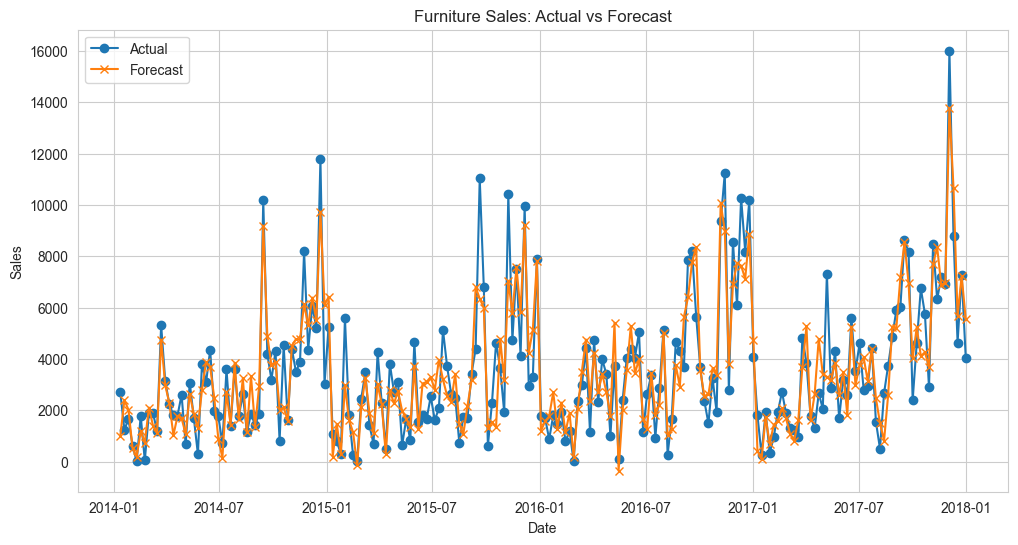

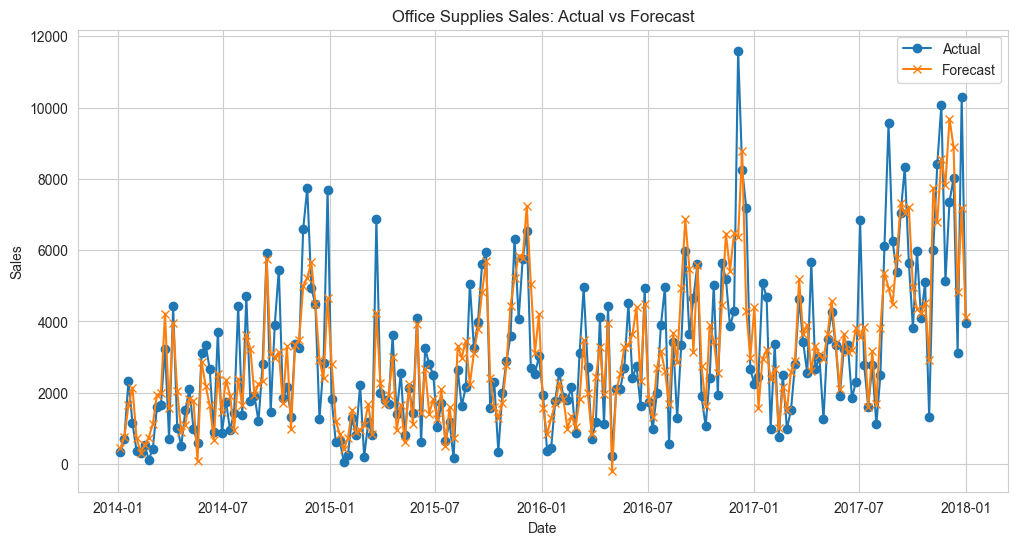

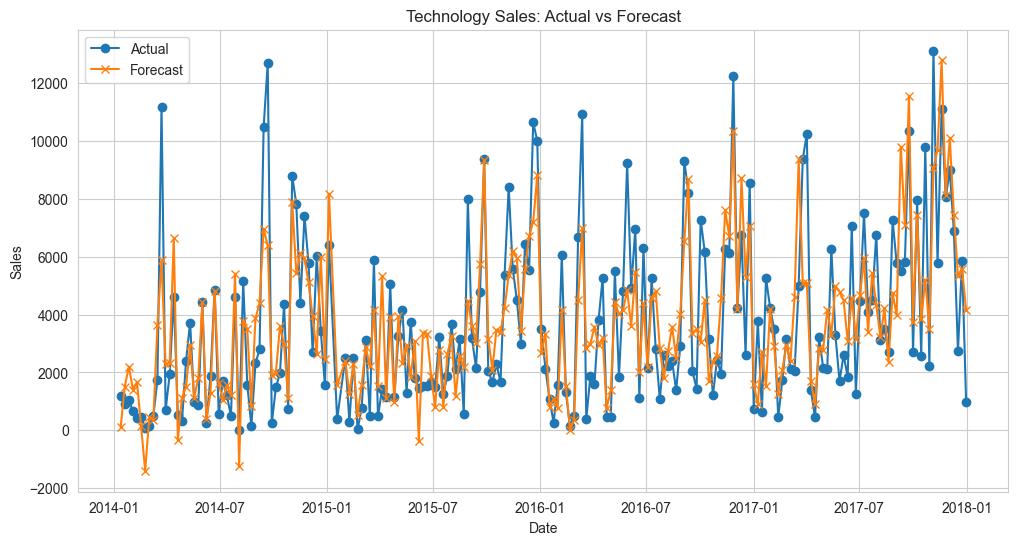

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
for cat in weekly['Category'].unique():
    fc_cat = forecast[forecast['Category']==cat].copy()
    actual_cat = weekly[weekly['Category']==cat].copy()

    plt.figure()
    plt.plot(actual_cat['ds'], actual_cat['y'], label='Actual', marker='o')
    plt.plot(fc_cat['ds'], fc_cat['yhat'], label='Forecast', marker='x')
    plt.title(f'{cat} Sales: Actual vs Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()


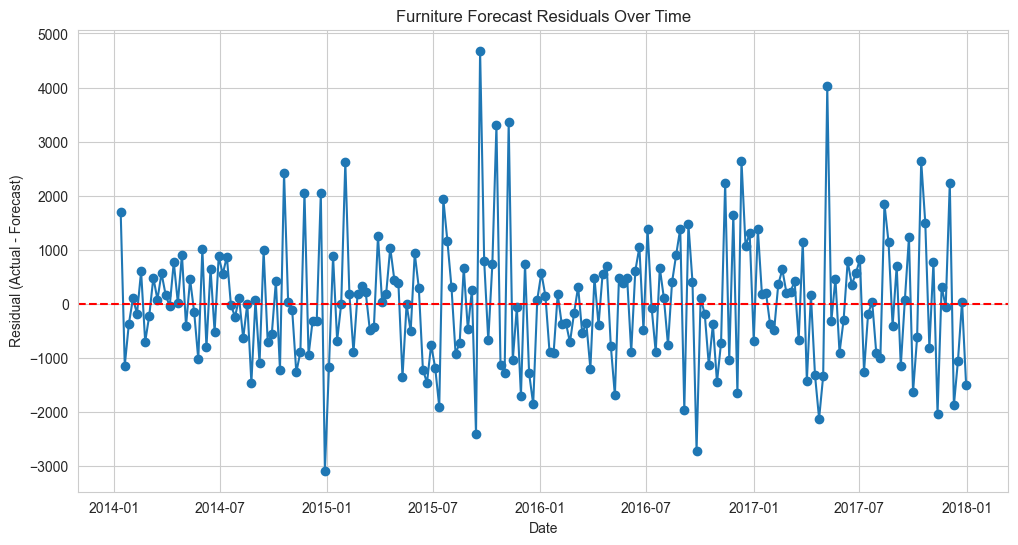

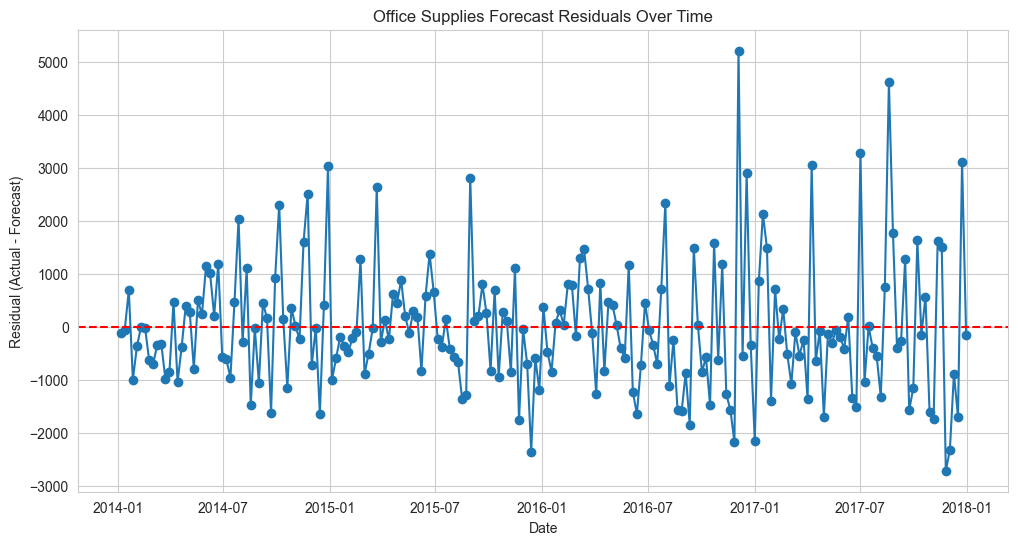

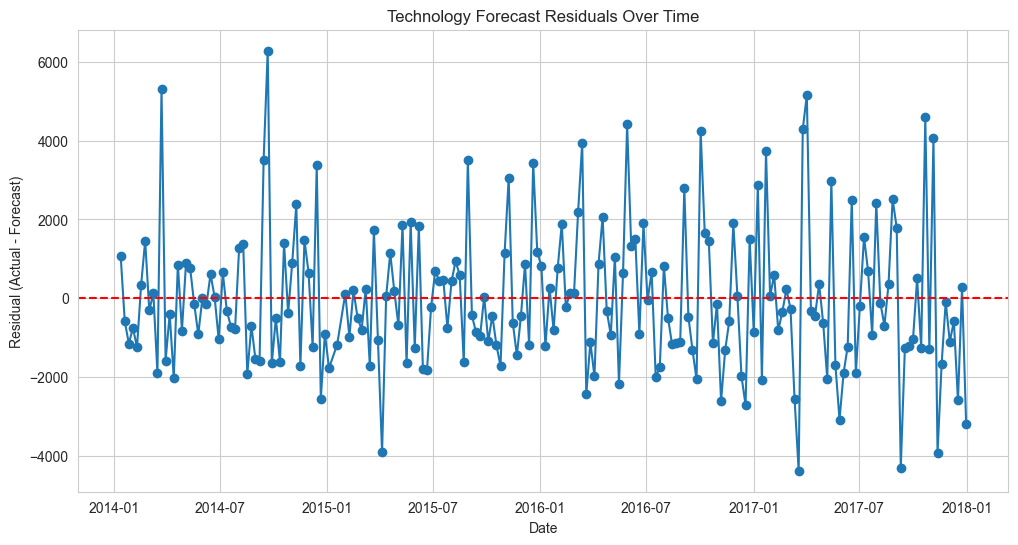

In [3]:
for cat in weekly['Category'].unique():
    fc_cat = forecast[forecast['Category']==cat].copy()
    actual_cat = weekly[weekly['Category']==cat].copy()
    merged = fc_cat.merge(actual_cat[['ds','y']], on='ds')
    merged['residual'] = merged['y'] - merged['yhat']

    plt.figure()
    plt.plot(merged['ds'], merged['residual'], marker='o')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{cat} Forecast Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residual (Actual - Forecast)')
    plt.show()


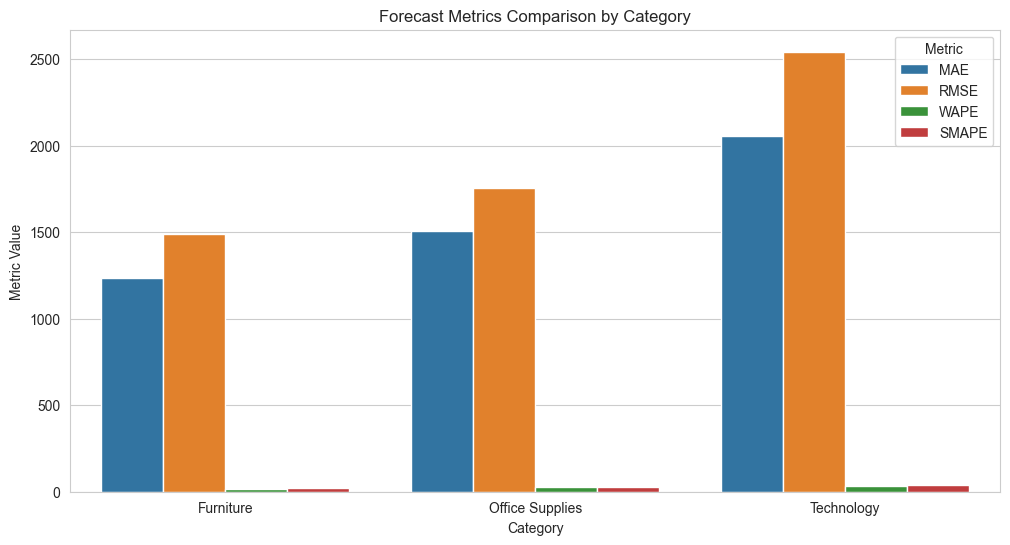

In [5]:
metrics_melt = metrics.melt(id_vars='Category', var_name='Metric', value_name='Value')
sns.barplot(x='Category', y='Value', hue='Metric', data=metrics_melt)
plt.title("Forecast Metrics Comparison by Category")
plt.ylabel("Metric Value")
plt.show()
